In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import deeplake
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision import transforms
from sklearn.metrics import (
    f1_score, precision_score, recall_score, hamming_loss,
    accuracy_score, roc_auc_score, multilabel_confusion_matrix,
    roc_curve, auc
)
from transformers import ViTForImageClassification, ViTImageProcessor
from PIL import Image
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Environment ready. Using device: {device}")

/Users/craigroberts/Documents/Coding/Machine_learning/Chest-X-R-AI/.venv/lib/python3.11/site-packages/deeplake/util/check_latest_version.py:32: UserWarning: A newer version of deeplake (4.2.1) is available. It's recommended that you update to the latest version using `pip install -U deeplake`.
  warnings.warn(


Environment ready. Using device: cpu


/Users/craigroberts/Documents/Coding/Machine_learning/Chest-X-R-AI/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/craigroberts/Documents/Coding/Machine_learning/Chest-X-R-AI/.venv/lib/python3.11/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/Users/craigroberts/Documents/Coding/Machine_learning/Chest-X-R-AI/.venv/lib/python3.11/site-packages/transformers/utils/generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(


In [2]:
def custom_collate_fn(batch):
    return {key: [sample[key] for sample in batch] for key in batch[0].keys()}

def custom_get_data(batch_size=32):
    ds_train = deeplake.load('hub://activeloop/nih-chest-xray-train')
    print("Train dataset loaded.")
    ds_test = deeplake.load('hub://activeloop/nih-chest-xray-test')
    print("Test dataset loaded.")
    train_loader = ds_train.pytorch(
        num_workers=2, batch_size=batch_size, shuffle=True,
        decode_method={"images": "pil"}, collate_fn=custom_collate_fn
    )
    test_loader = ds_test.pytorch(
        batch_size=batch_size, shuffle=False,
        decode_method={"images": "pil"}, collate_fn=custom_collate_fn
    )
    print("DataLoader objects created.")
    return train_loader, test_loader

train_loader, test_loader = custom_get_data()

\

Opening dataset in read-only mode as you don't have write permissions.


\

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/nih-chest-xray-train



/

hub://activeloop/nih-chest-xray-train loaded successfully.



Train dataset loaded.


|

Opening dataset in read-only mode as you don't have write permissions.


\

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/nih-chest-xray-test



/

hub://activeloop/nih-chest-xray-test loaded successfully.



Test dataset loaded.
DataLoader objects created.


In [3]:
def get_transforms():
    processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")
    def transform_fn(pil_img):
        if pil_img.mode != "RGB":
            pil_img = pil_img.convert("RGB")
        return processor(images=pil_img, return_tensors="pt")["pixel_values"].squeeze(0)
    return transform_fn

class ViTModelWrapper(nn.Module):
    def __init__(self, num_classes=15):
        super(ViTModelWrapper, self).__init__()
        self.model = ViTForImageClassification.from_pretrained(
            "google/vit-base-patch16-224-in21k",
            num_labels=num_classes,
            ignore_mismatched_sizes=True
        )
    def forward(self, x):
        return self.model(x).logits

transform_pipeline = get_transforms()
model = ViTModelWrapper(num_classes=15).to(device)
print("Model and transform pipeline ready.")

/Users/craigroberts/Documents/Coding/Machine_learning/Chest-X-R-AI/.venv/lib/python3.11/site-packages/huggingface_hub/file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model and transform pipeline ready.


In [4]:
def convert_labels_to_multihot(raw_labels, num_classes=15):
    processed_labels = []
    for label in raw_labels:
        multi_hot = torch.zeros(num_classes, dtype=torch.float)
        for item in label:
            try:
                idx = int(item)
                if 0 <= idx < num_classes:
                    multi_hot[idx] = 1.0
            except:
                continue
        processed_labels.append(multi_hot)
    return torch.stack(processed_labels)

print("Label conversion function defined.")

Label conversion function defined.


Starting training...

Epoch 1 started...


Epoch 1:   0%|          | 0/2704 [00:00<?, ?it/s]
Please wait, filling up the shuffle buffer with samples.:   0%|          | 0.00/1.91G [00:00<?, ?B/s]
Please wait, filling up the shuffle buffer with samples.:   0%|          | 1.00M/1.91G [00:14<7:37:09, 74.6kB/s]
Please wait, filling up the shuffle buffer with samples.:   3%|▎         | 68.0M/1.91G [00:16<05:53, 5.59MB/s]  
Please wait, filling up the shuffle buffer with samples.:   5%|▌         | 100M/1.91G [00:17<03:29, 9.27MB/s] 
Please wait, filling up the shuffle buffer with samples.:   7%|▋         | 132M/1.91G [00:19<03:00, 10.6MB/s]
Please wait, filling up the shuffle buffer with samples.:   8%|▊         | 164M/1.91G [00:19<01:58, 15.8MB/s]
Please wait, filling up the shuffle buffer with samples.:  10%|█         | 196M/1.91G [00:21<01:51, 16.5MB/s]
Please wait, filling up the shuffle buffer with samples.:  12%|█▏        | 231M/1.91G [00:21<01:15, 23.9MB/s]
Please wait, filling up the shuffle buffer with samples.:  13%|█▎      

Shuffle buffer filling is complete.


Epoch 1: 100%|██████████| 2704/2704 [4:18:32<00:00,  5.74s/it]    


Epoch 1 complete:
Loss = 17278.1733
Accuracy = 0.4937
F1 Micro = 0.5168
F1 Macro = 0.0653
Hamming = 0.0626
AUC = 0.5143


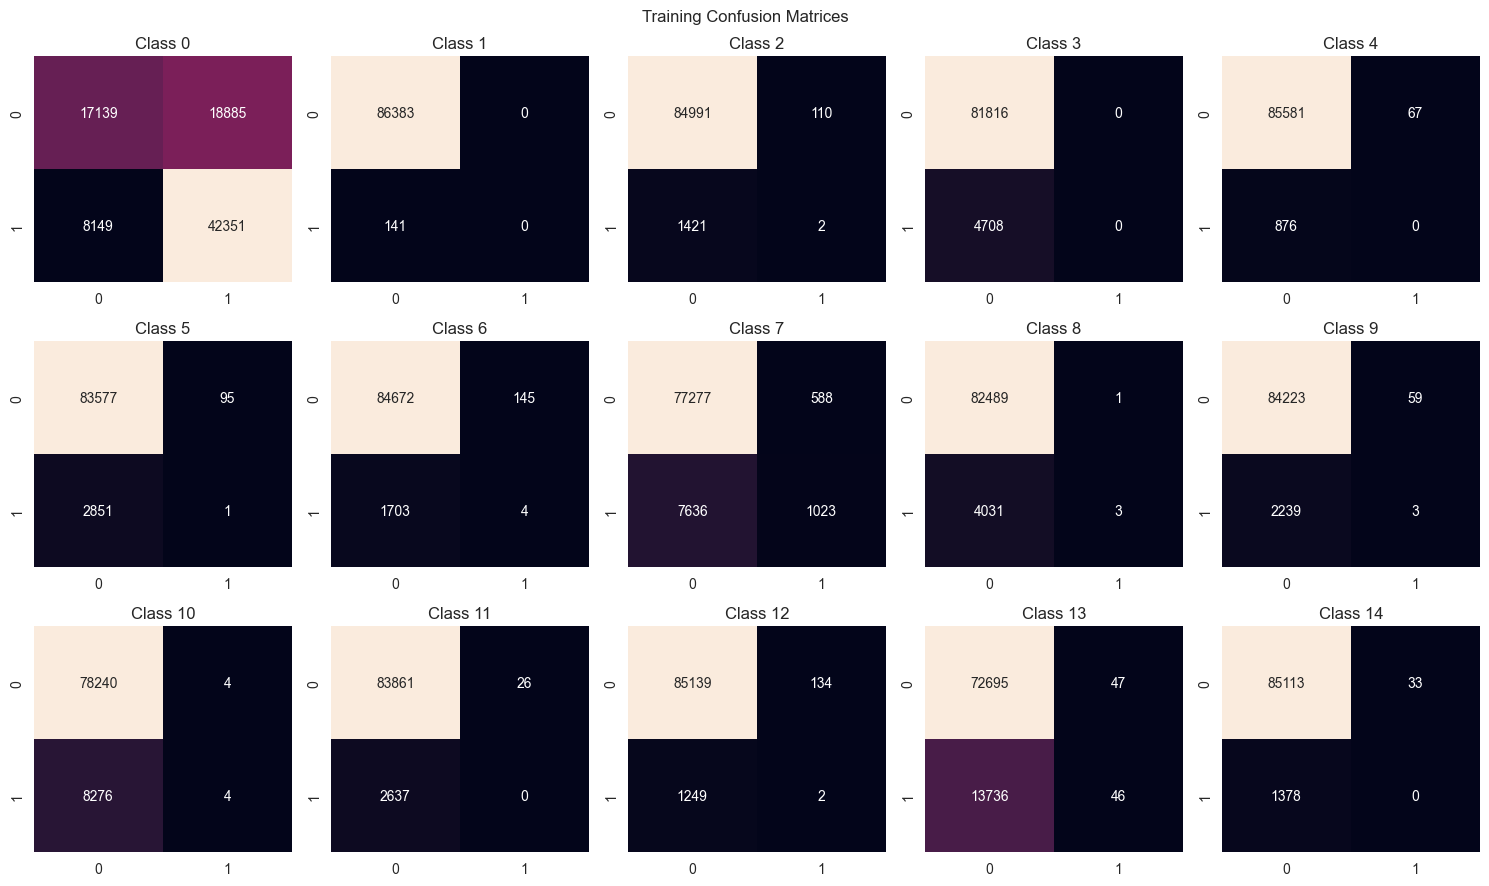

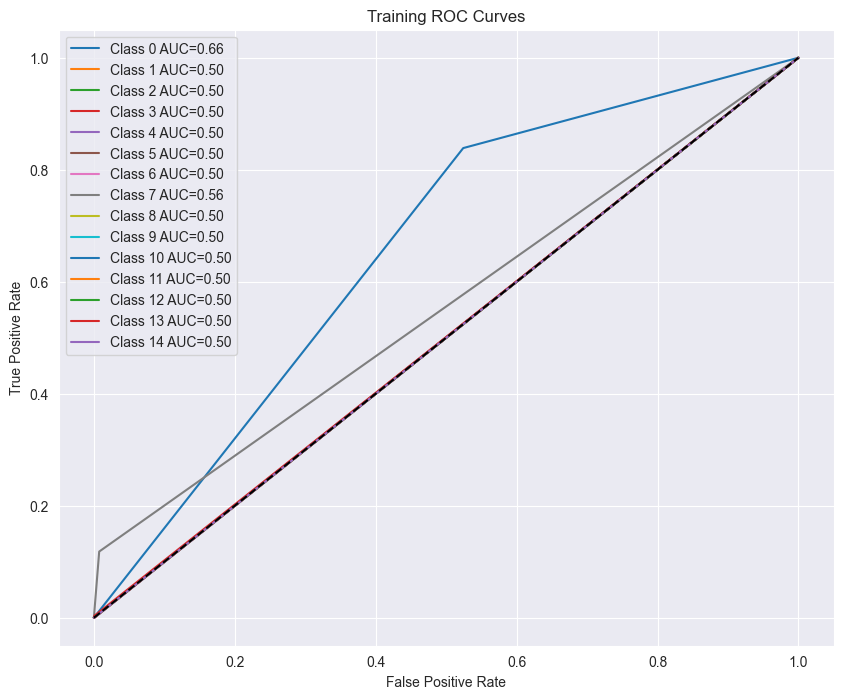

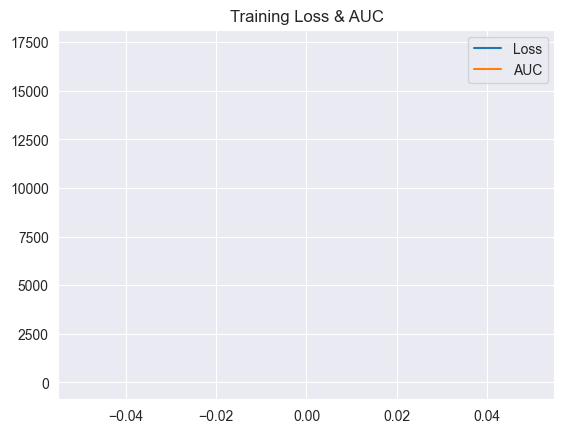

Training complete and model saved.


In [5]:
def train_model(model, train_loader, transform_pipeline, device, num_epochs=1):
    print("Starting training...")
    epoch_losses = []
    epoch_aucs = []
    model.to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=3e-5)
    model.train()

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1} started...")
        running_loss = 0.0
        all_preds, all_targets = [], []

        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            images = torch.stack([transform_pipeline(img) for img in batch["images"]]).to(device)
            labels = convert_labels_to_multihot(batch.get("labels") or batch["findings"]).to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            preds = (torch.sigmoid(outputs) > 0.5).float()
            all_preds.append(preds.cpu())
            all_targets.append(labels.cpu())

        preds_all = torch.cat(all_preds)
        targets_all = torch.cat(all_targets)

        accuracy = accuracy_score(targets_all, preds_all)
        f1_micro = f1_score(targets_all, preds_all, average='micro')
        f1_macro = f1_score(targets_all, preds_all, average='macro')
        hamming = hamming_loss(targets_all, preds_all)
        auc_macro = roc_auc_score(targets_all, preds_all, average='macro')

        print(f"Epoch {epoch+1} complete:\nLoss = {running_loss:.4f}\nAccuracy = {accuracy:.4f}\nF1 Micro = {f1_micro:.4f}\nF1 Macro = {f1_macro:.4f}\nHamming = {hamming:.4f}\nAUC = {auc_macro:.4f}")

        epoch_losses.append(running_loss)
        epoch_aucs.append(auc_macro)

        # Confusion Matrices
        cm = multilabel_confusion_matrix(targets_all, preds_all)
        fig, axes = plt.subplots(3, 5, figsize=(15, 9))
        for i, ax in enumerate(axes.flat):
            sns.heatmap(cm[i], annot=True, fmt='d', ax=ax, cbar=False)
            ax.set_title(f'Class {i}')
        plt.suptitle('Training Confusion Matrices')
        plt.tight_layout()
        plt.savefig("train_combined_conf_matrix.png")
        plt.show()

        # Combined ROC Curve
        plt.figure(figsize=(10, 8))
        for i in range(preds_all.shape[1]):
            try:
                fpr, tpr, _ = roc_curve(targets_all[:, i], preds_all[:, i])
                roc_auc = auc(fpr, tpr)
                plt.plot(fpr, tpr, label=f'Class {i} AUC={roc_auc:.2f}')
            except:
                continue
        plt.plot([0, 1], [0, 1], 'k--')
        plt.title("Training ROC Curves")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.legend()
        plt.savefig("train_roc_curve.png")
        plt.show()

    plt.plot(epoch_losses, label="Loss")
    plt.plot(epoch_aucs, label="AUC")
    plt.legend()
    plt.title("Training Loss & AUC")
    plt.savefig("training_metrics.png")
    plt.show()

    torch.save(model.state_dict(), "ViT_model.pth")
    print("Training complete and model saved.")

train_model(model, train_loader, transform_pipeline, device)

Loading test dataset...


\

Opening dataset in read-only mode as you don't have write permissions.


\

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/nih-chest-xray-test



\

hub://activeloop/nih-chest-xray-test loaded successfully.



Loaded 25596 test samples
Loading model...


/Users/craigroberts/Documents/Coding/Machine_learning/Chest-X-R-AI/.venv/lib/python3.11/site-packages/huggingface_hub/file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded and moved to device.


Running Inference: 100%|██████████| 800/800 [23:47<00:00,  1.78s/it]



Test Results:
Loss = 0.2434
Accuracy = 0.2039
F1 Micro = 0.2529
F1 Macro = 0.0573
Hamming Loss = 0.0897
AUC (Macro) = 0.5166


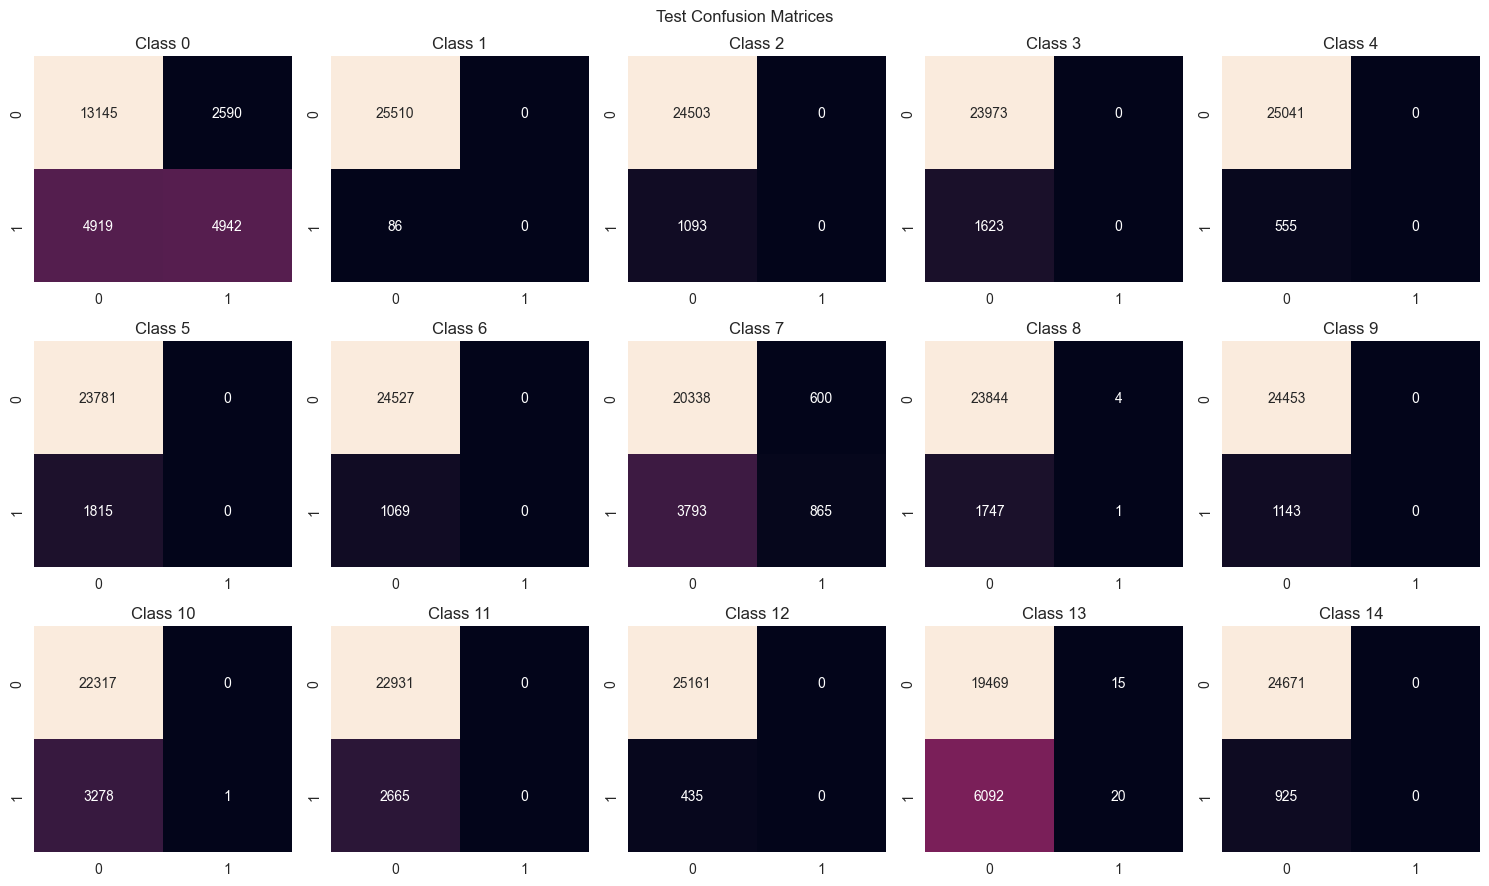

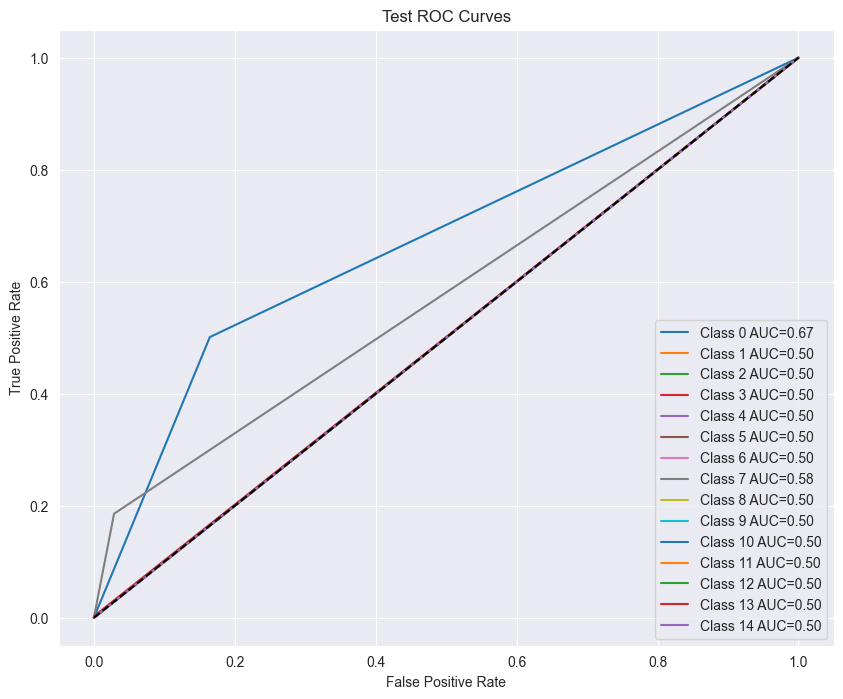

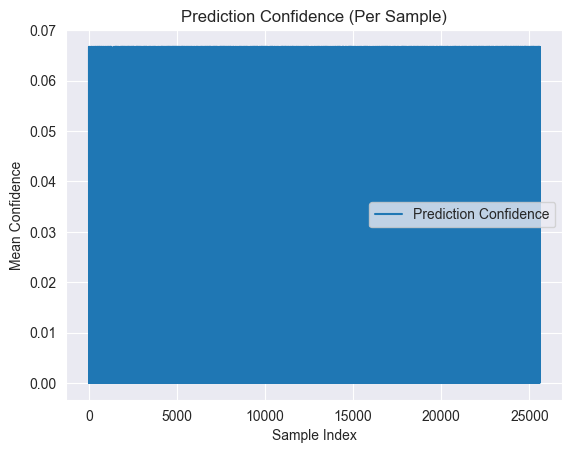

Testing complete. All metrics and plots saved.


'\nTest Results:\nLoss = 0.2434\nAccuracy = 0.2039\nF1 Micro = 0.2529\nF1 Macro = 0.0573\nHamming Loss = 0.0897\nAUC (Macro) = 0.5166\nTesting complete. All metrics and plots saved.'

In [14]:
# Testing Part

import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
import deeplake
from tqdm import tqdm
from transformers import ViTForImageClassification, ViTImageProcessor
from sklearn.metrics import (
    accuracy_score, f1_score, hamming_loss, roc_auc_score,
    multilabel_confusion_matrix, roc_curve, auc
)
import numpy as np

NUM_CLASSES = 15
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_PATH = "ViT_model.pth"
BATCH_SIZE = 32

class ViTModelWrapper(nn.Module):
    def __init__(self, num_classes=NUM_CLASSES):
        super(ViTModelWrapper, self).__init__()
        self.model = ViTForImageClassification.from_pretrained(
            "google/vit-base-patch16-224-in21k",
            num_labels=num_classes,
            ignore_mismatched_sizes=True
        )

    def forward(self, x):
        return self.model(x).logits

def convert_labels_to_multihot(raw_labels, num_classes=NUM_CLASSES):
    processed_labels = []
    for label in raw_labels:
        multi_hot = torch.zeros(num_classes, dtype=torch.float)
        for item in label:
            try:
                idx = int(item)
                if 0 <= idx < num_classes:
                    multi_hot[idx] = 1.0
            except:
                continue
        processed_labels.append(multi_hot)
    return torch.stack(processed_labels)

def custom_collate_fn(batch):
    return {key: [sample[key] for sample in batch] for key in batch[0].keys()}

print("Loading test dataset...")
ds_test = deeplake.load('hub://activeloop/nih-chest-xray-test')
test_loader = ds_test.pytorch(
    batch_size=BATCH_SIZE, shuffle=False,
    decode_method={"images": "pil"}, collate_fn=custom_collate_fn
)
print(f"Loaded {len(ds_test)} test samples")

print("Loading model...")
model = ViTModelWrapper(num_classes=NUM_CLASSES)
model.load_state_dict(torch.load(MODEL_PATH))
model.to(DEVICE)
model.eval()
print("Model loaded and moved to device.")

processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")
criterion = nn.BCEWithLogitsLoss()

all_preds, all_targets = [], []
total_loss = 0.0

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Running Inference"):
        images = [img.convert("RGB") if img.mode != "RGB" else img for img in batch["images"]]
        inputs = torch.stack([processor(images=img, return_tensors="pt")["pixel_values"].squeeze(0) for img in images]).to(DEVICE)
        labels = convert_labels_to_multihot(batch.get("labels") or batch["findings"]).to(DEVICE)

        logits = model(inputs)
        loss = criterion(logits, labels)
        total_loss += loss.item() * inputs.size(0)

        probs = torch.sigmoid(logits)
        preds = (probs > 0.5).float()

        all_preds.append(preds.cpu())
        all_targets.append(labels.cpu())

preds_all = torch.cat(all_preds)
targets_all = torch.cat(all_targets)
avg_loss = total_loss / len(ds_test)

accuracy = accuracy_score(targets_all, preds_all)
f1_micro = f1_score(targets_all, preds_all, average='micro')
f1_macro = f1_score(targets_all, preds_all, average='macro')
hamming = hamming_loss(targets_all, preds_all)
auc_macro = roc_auc_score(targets_all, preds_all, average='macro')

print("\nTest Results:")
print(f"Loss = {avg_loss:.4f}")
print(f"Accuracy = {accuracy:.4f}")
print(f"F1 Micro = {f1_micro:.4f}")
print(f"F1 Macro = {f1_macro:.4f}")
print(f"Hamming Loss = {hamming:.4f}")
print(f"AUC (Macro) = {auc_macro:.4f}")

cm = multilabel_confusion_matrix(targets_all, preds_all)
fig, axes = plt.subplots(3, 5, figsize=(15, 9))
for i, ax in enumerate(axes.flat):
    sns.heatmap(cm[i], annot=True, fmt='d', ax=ax, cbar=False)
    ax.set_title(f'Class {i}')
plt.suptitle('Test Confusion Matrices')
plt.tight_layout()
plt.savefig("test_combined_conf_matrix.png")
plt.show()

plt.figure(figsize=(10, 8))
for i in range(preds_all.shape[1]):
    try:
        fpr, tpr, _ = roc_curve(targets_all[:, i], preds_all[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Class {i} AUC={roc_auc:.2f}')
    except:
        continue
plt.plot([0, 1], [0, 1], 'k--')
plt.title("Test ROC Curves")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.savefig("test_roc_curve.png")
plt.show()

plt.plot(preds_all.mean(axis=1), label='Prediction Confidence')
plt.title('Prediction Confidence (Per Sample)')
plt.xlabel('Sample Index')
plt.ylabel('Mean Confidence')
plt.savefig("test_prediction_confidence.png")
plt.legend()
plt.show()

print("Testing complete. All metrics and plots saved.")
"""
Test Results:
Loss = 0.2434
Accuracy = 0.2039
F1 Micro = 0.2529
F1 Macro = 0.0573
Hamming Loss = 0.0897
AUC (Macro) = 0.5166
Testing complete. All metrics and plots saved."""